<a href="https://colab.research.google.com/github/Brokencarer/Colored-cell-damage-detection/blob/main/find_green_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

标注结果:


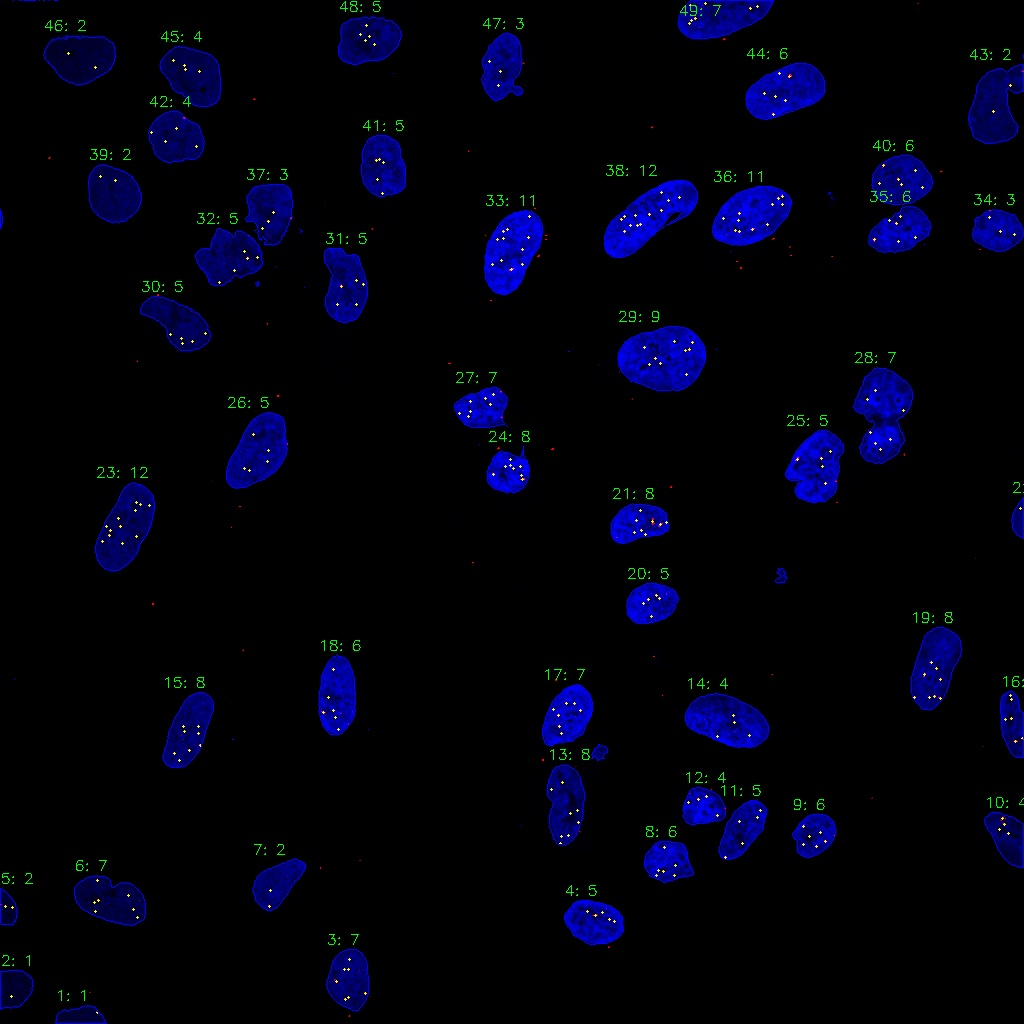


中间步骤:


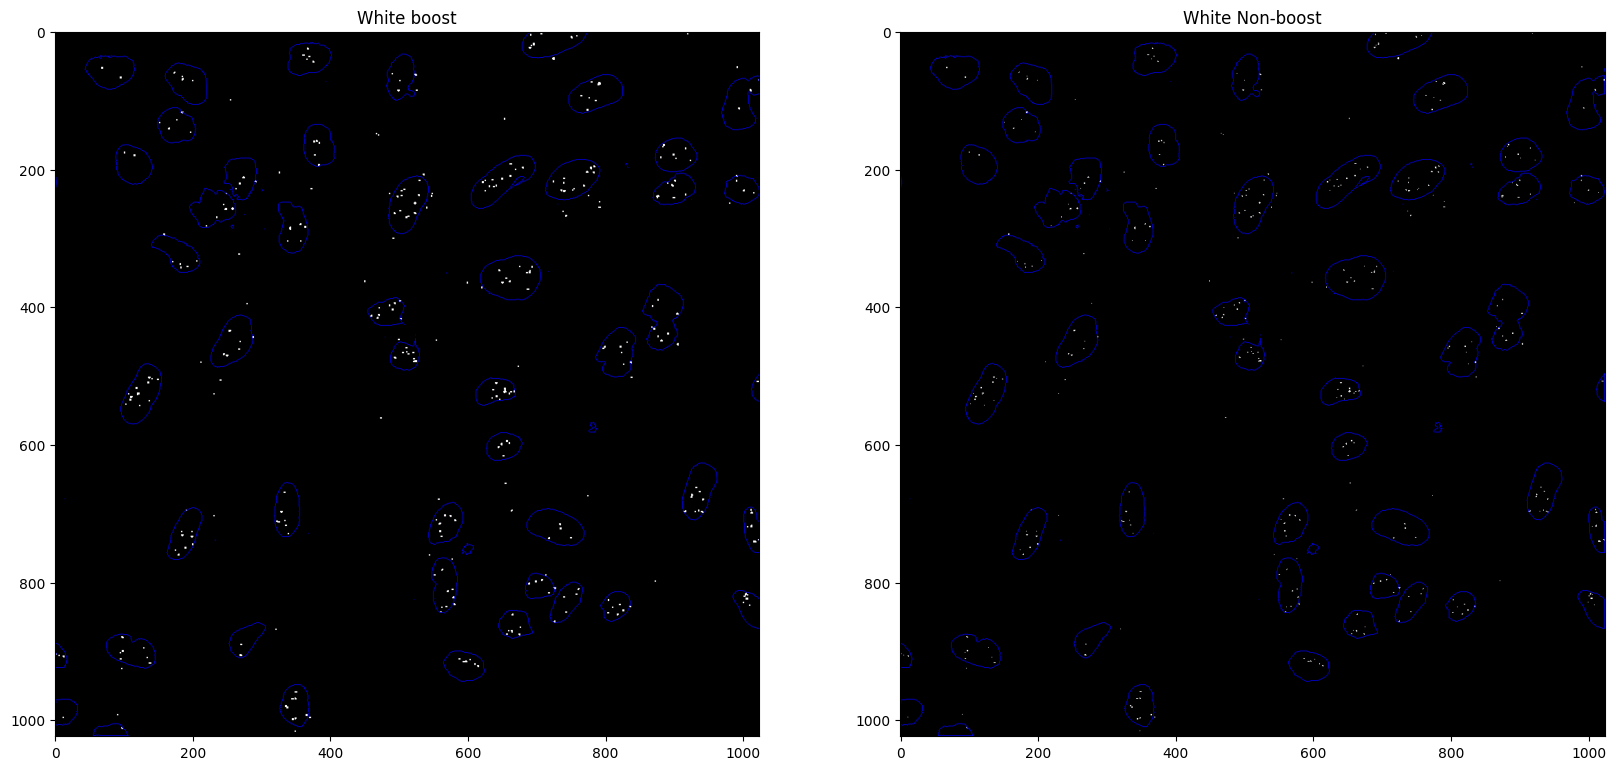

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from IPython.display import display, Image

def count_green_points_in_blue_area(image_path):
    # 创建保存目录
    save_dir = 'save'
    os.makedirs(save_dir, exist_ok=True)

    # 1. 读取图像
    image = cv2.imread(image_path)
    if image is None:
        print("图片加载失败")
        return
    # 2. 颜色空间转换
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # 3. 提取蓝色区域
    lower_blue = np.array([100, 180, 30])
    upper_blue = np.array([140, 255, 255])
    blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)

    # 4. 提取绿色区域
    #lower_green = np.array([5, 2, 20]) #绿色
    #upper_green = np.array([130, 180, 255]) #绿色
    lower_green = np.array([150, 190, 20]) #橙色
    upper_green = np.array([180, 255, 255]) #橙色
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
    green_white_only_mask = green_mask

    # 5. 形态学操作增强检测
    kernel = np.ones((2, 2), np.uint8)
    green_mask = cv2.dilate(green_mask, kernel, iterations=1)

    # 6. 查找轮廓
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours_green, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # 7. 提取绿色点坐标
    green_points = []
    for cnt_green in contours_green:
        M = cv2.moments(cnt_green)
        if M["m00"] == 0:
            continue
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
        for contour in contours:
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                green_points.append((x, y))
                break

    # 8. 创建结果图像
    image_with_green_points = image.copy()
    # 绘制所有绿色点（红色显示）
    for point in green_points:
        cv2.circle(image_with_green_points, point, 1, (0, 255, 255), -1)

    cv2.drawContours(image_with_green_points, contours, -1, (255, 0, 0), 1)
    green_white_only = cv2.cvtColor(green_white_only_mask, cv2.COLOR_GRAY2BGR)
    green_with_blue_contours = cv2.cvtColor(green_mask, cv2.COLOR_GRAY2BGR)  # 将绿色掩膜转换为彩色图像
    cv2.drawContours(green_with_blue_contours, contours, -1, (255, 0, 0), 1)  # 使用蓝色（BGR格式）绘制轮廓
    cv2.drawContours(green_white_only, contours, -1, (255, 0, 0), 1)  # 使用蓝色（BGR格式）绘制轮廓

    # 9. 统计数据并标注
    data = []
    count_0 = 0

    for idx, contour in enumerate(contours, start=1):
        current_count_0 = count_0
        count = 0

        # 计算绿点数量
        for (x, y) in green_points:
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                count += 1

        # 获取标注位置
        x_rect, y_rect, w, h = cv2.boundingRect(contour)
        text_pos = (x_rect, y_rect - 5) if y_rect - 5 > 0 else (x_rect, y_rect + 15)

        if count > 0:
            displayed_serial = idx - current_count_0
            data.append({"细胞序号": displayed_serial, "绿点数量": count})

            # 添加标注
            cv2.putText(
                image_with_green_points,
                f"{displayed_serial}: {count}",
                text_pos,
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (0, 255, 0),
                1
            )
        else:
            count_0 += 1

    # 10. 保存结果
    result_path = "annotated_result.jpg"
    result_path = os.path.join(save_dir, "annotated_result.jpg")
    cv2.imwrite(result_path, image_with_green_points)
    cv2.imwrite("White_boost.jpg", green_with_blue_contours)
    cv2.imwrite("White_Non_boost.jpg", green_white_only)

    print("标注结果:")
    display(Image(result_path))

    print("\n中间步骤:")
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(green_with_blue_contours, cv2.COLOR_BGR2RGB))
    plt.title('White boost')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(green_white_only, cv2.COLOR_BGR2RGB))
    plt.title('White Non-boost')
    plt.show()

    # 导出Excel
    if data:
        df = pd.DataFrame(data)
        excel_path = os.path.join(save_dir, "results.xlsx")
        df.to_excel(excel_path, index=False)
        #print("\n统计结果:")
        #display(df)

        # 提供下载链接
        from google.colab import files
        files.download(excel_path)
        files.download(result_path)
        files.download("White_boost.jpg")
        files.download("White_Non_boost.jpg")

    else:
        print("未检测到包含绿点的蓝色区域")

# 在Colab中使用时，需要先上传图片
# 使用以下代码上传图片（取消注释使用）
# from google.colab import files
# uploaded = files.upload()

# 使用示例（根据上传的文件名修改）
image_path = 'S34F 160ng Dox Image001.png'
count_green_points_in_blue_area(image_path)